In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [18]:
#DADOS DO PROBLEMA
N = 12
Do = 2e-2
A = np.pi * (Do**2) / 4.0
mu = 1e-3
rho = 1e3
dt = 1.0
L = 5.0
Uin = 10.0
dx = L / (N - 2) # dx baseado nos volumes reais
n_iter_global = 100
n_iter_massa = 2

#Inicialização
u = np.ones(N) * Uin
p = np.zeros(N)
u_old = u.copy()
x_p = np.zeros(N)

#Posicionamento dos nós (incluindo fictícios)
for i in range(1, N-1):
    x_p[i] = (i - 0.5) * dx
x_p[0], x_p[N-1] = 0.0, L

In [19]:
#Solver TDMA [cite: 58-62]
def tdma(a, b, c, d):
    n = len(d)
    P, Q, T = np.zeros(n), np.zeros(n), np.zeros(n)
    P[0], Q[0] = c[0]/a[0], d[0]/a[0]
    for i in range(1, n):
        den = a[i] - b[i]*P[i-1]
        P[i] = c[i]/den
        Q[i] = (d[i] + b[i]*Q[i-1])/den
    T[-1] = Q[-1]
    for i in range(n-2, -1, -1):
        T[i] = P[i]*T[i+1] + Q[i]
    return T

hist_uN = []
hist_dp = []

In [20]:
#LOOP NUMÉRICO ---
for it in range(n_iter_global):
    # Coeficientes QML (Velocidade)
    aw_u, ae_u, ap_u, bp_u = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
    
    for i in range(1, N-1):
        # Termos Difusivos e Advectivos
        dif = (mu * A) / dx
        adv = rho * u[i] * A
        
        aw_u[i] = dif + max(adv, 0)
        ae_u[i] = dif + max(-adv, 0)
        ap_u[i] = (rho * A * dx / dt) + aw_u[i] + ae_u[i]
        
        # Pressão (CDS) 
        # Nota: i-1 e i+1 são vizinhos diretos
        grad_p = A * (p[i+1] - p[i-1]) / 2.0
        bp_u[i] = (rho * A * dx / dt) * u_old[i] - grad_p

    # Condições de Contorno (Volumes Fictícios)
    ap_u[0], bp_u[0] = 1.0, Uin
    ap_u[N-1], aw_u[N-1], bp_u[N-1] = 1.0, 1.0, 0.0 
    
    u = tdma(ap_u, aw_u, ae_u, bp_u)
    
    # Ciclo da MASSA (Pressão) 
    for _ in range(n_iter_massa):
        aw_p, ae_p, ap_p, bp_p = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
        for i in range(1, N-1):
            aw_p[i] = 1.0
            ae_p[i] = 1.0
            ap_p[i] = aw_p[i] + ae_p[i]
            # Conservação da massa 
            bp_p[i] = -(rho * A * (u[i] - u[i-1])) 
            
        ap_p[0], bp_p[0] = 1.0, 0.0
        ap_p[N-1], aw_p[N-1], bp_p[N-1] = 1.0, 1.0, 0.0
        p = tdma(ap_p, aw_p, ae_p, bp_p)

    hist_uN.append(u[N-1])
    hist_dp.append(p[1] - p[N-1])
    u_old = u.copy()

In [21]:
#PÓS-PROCESSAMENTO
u_final = u.copy()
p_final = p.copy()

u_final[0] = Uin
u_final[N-1] = (u[N-2] + u[N-1]) / 2.0
p_final[0] = (p[0] + p[1]) / 2.0 
p_final[N-1] = (p[N-2] + p[N-1]) / 2.0

pref = p_final[0]
for P in range(N):
    p_final[P] = p_final[P] - pref

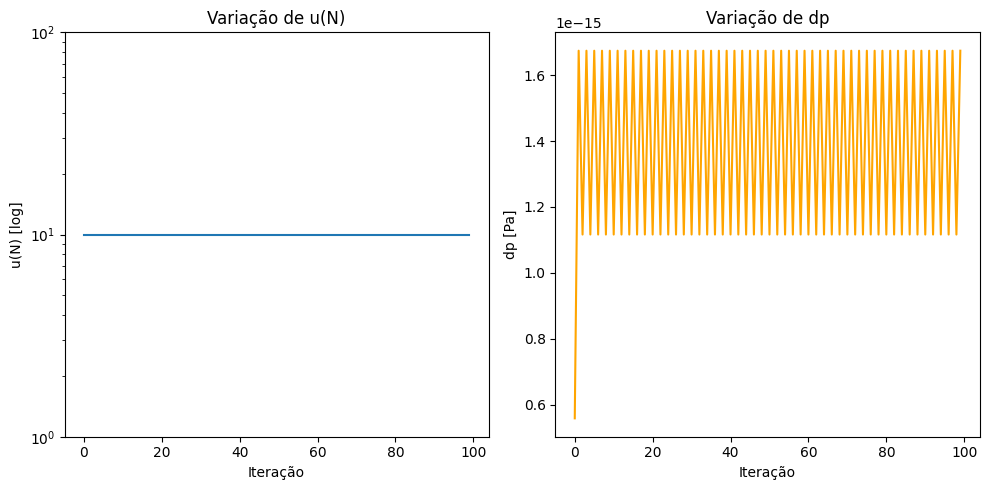

In [22]:
#ITEM 1
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.semilogy(np.abs(hist_uN), label='u(N)')
plt.title('Variação de u(N)')
plt.xlabel('Iteração'); plt.ylabel('u(N) [log]')

plt.subplot(1, 2, 2)
plt.plot(hist_dp, label='dp = p(2)-p(N)', color='orange')
plt.title('Variação de dp')
plt.xlabel('Iteração'); plt.ylabel('dp [Pa]')
plt.tight_layout()
plt.show()

--- Tabela Itens 2 e 3 ---
 Nó   xP       aw           ae       ap        bp   uP
  1 0.00 0.000000 0.000000e+00 1.000000 10.000000 10.0
  2 0.25 3.141593 6.283185e-07 3.298674  1.570796 10.0
  3 0.75 3.141593 6.283185e-07 3.298674  1.570796 10.0
  4 1.25 3.141593 6.283185e-07 3.298674  1.570796 10.0
  5 1.75 3.141593 6.283185e-07 3.298674  1.570796 10.0
  6 2.25 3.141593 6.283185e-07 3.298674  1.570796 10.0
  7 2.75 3.141593 6.283185e-07 3.298674  1.570796 10.0
  8 3.25 3.141593 6.283185e-07 3.298674  1.570796 10.0
  9 3.75 3.141593 6.283185e-07 3.298674  1.570796 10.0
 10 4.25 3.141593 6.283185e-07 3.298674  1.570796 10.0
 11 4.75 3.141593 6.283185e-07 3.298674  1.570796 10.0
 12 5.00 1.000000 0.000000e+00 1.000000  0.000000 10.0


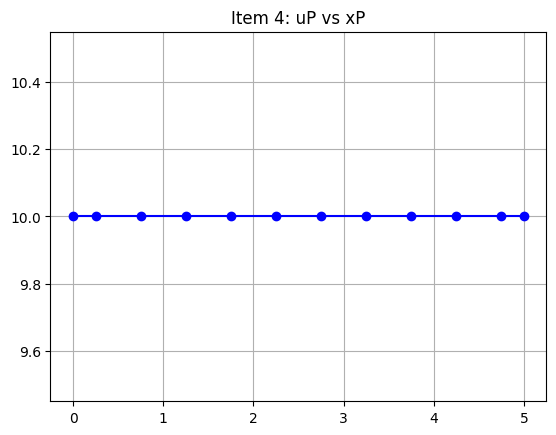

In [23]:
#ITEM 2, 3 E 4
data_u = {'Nó': np.arange(1, N+1), 'xP': x_p, 'aw': aw_u, 'ae': ae_u, 'ap': ap_u, 'bp': bp_u, 'uP': u_final}
df_u = pd.DataFrame(data_u)
print("--- Tabela Itens 2 e 3 ---")
print(df_u.to_string(index=False))

plt.figure()
plt.plot(x_p, u_final, 'bo-')
plt.title('Item 4: uP vs xP')
plt.grid(True); plt.show()


--- Tabela Item 5 (Faces Leste) ---
 Nó   xe   ue
  1 0.25 10.0
  2 0.50 10.0
  3 1.00 10.0
  4 1.50 10.0
  5 2.00 10.0
  6 2.50 10.0
  7 3.00 10.0
  8 3.50 10.0
  9 4.00 10.0
 10 4.50 10.0
 11 5.00 10.0
 12 5.00  0.0


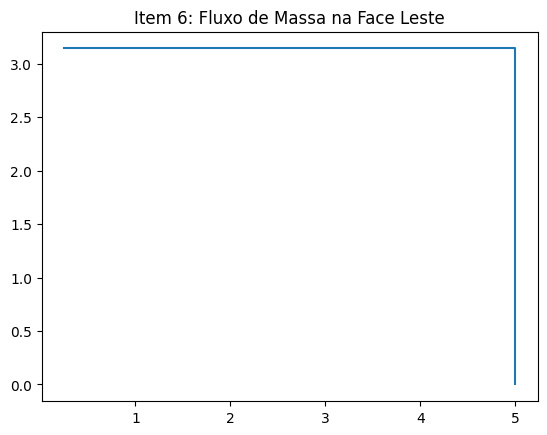

In [24]:
#ITEM 5 E 6
xe = x_p + dx/2
xe[-1] = L
ue = np.zeros(N)
fluxo = np.zeros(N)
for i in range(N-1):
    ue[i] = (u_final[i] + u_final[i+1]) / 2
    fluxo[i] = rho * ue[i] * A

print("\n--- Tabela Item 5 (Faces Leste) ---")
print(pd.DataFrame({'Nó': np.arange(1, N+1), 'xe': xe, 'ue': ue}).to_string(index=False))

plt.figure()
plt.step(xe, fluxo, where='post')
plt.title('Item 6: Fluxo de Massa na Face Leste')
plt.show()


--- Tabela Itens 7 e 8 ---
 Nó   xP  aw  ap  ae            bp            pP
  1 0.00 0.0 1.0 0.0  0.000000e+00  0.000000e+00
  2 0.25 1.0 2.0 1.0 -0.000000e+00 -5.580590e-16
  3 0.75 1.0 2.0 1.0 -5.580590e-16 -1.674177e-15
  4 1.25 1.0 2.0 1.0 -5.580590e-16 -2.232236e-15
  5 1.75 1.0 2.0 1.0 -0.000000e+00 -2.232236e-15
  6 2.25 1.0 2.0 1.0 -0.000000e+00 -2.232236e-15
  7 2.75 1.0 2.0 1.0 -0.000000e+00 -2.232236e-15
  8 3.25 1.0 2.0 1.0 -0.000000e+00 -2.232236e-15
  9 3.75 1.0 2.0 1.0 -0.000000e+00 -2.232236e-15
 10 4.25 1.0 2.0 1.0 -0.000000e+00 -2.232236e-15
 11 4.75 1.0 2.0 1.0 -0.000000e+00 -2.232236e-15
 12 5.00 1.0 1.0 0.0  0.000000e+00 -2.232236e-15


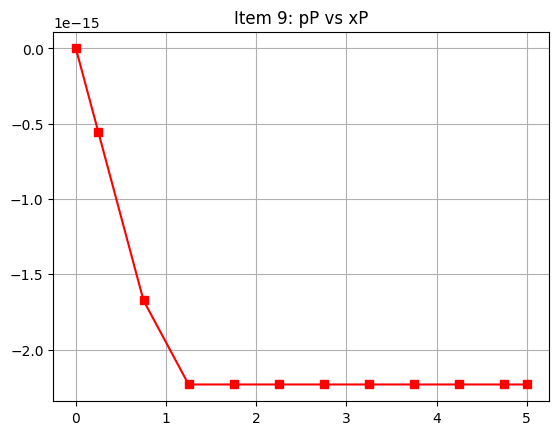

In [25]:
#ITEM 7, 8 E 9
data_p = {'Nó': np.arange(1, N+1), 'xP': x_p, 'aw': aw_p, 'ap': ap_p, 'ae': ae_p, 'bp': bp_p, 'pP': p_final}
df_p = pd.DataFrame(data_p)
print("\n--- Tabela Itens 7 e 8 ---")
print(df_p.to_string(index=False))

plt.figure()
plt.plot(x_p, p_final, 'rs-')
plt.title('Item 9: pP vs xP')
plt.grid(True); plt.show()